# Step 1：Precessing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/cars.zip'

extract_to_path = '/content/car_data'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"zip to: {extract_to_path}")

zip to: /content/car_data


In [47]:
import os
import pandas as pd
import shutil
from ultralytics import YOLO
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

# Step 2： Training

In [12]:

def process_and_split_data(csv_path, images_path, output_dir, test_size=0.2):
    labels = {}
    data = pd.read_csv(csv_path)

    # creating yolo_dataset
    train_images_dir = os.path.join(output_dir, 'train', 'images')
    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    for _, row in data.iterrows():
        image_id = row['image']
        x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        image_path = os.path.join(images_path, image_id)

        if not os.path.exists(image_path):
            print(f"Image {image_id} not found, skipping.")
            continue

        img = Image.open(image_path)
        img_width, img_height = img.size

        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        if image_id not in labels:
            labels[image_id] = []
        labels[image_id].append(f"0 {x_center} {y_center} {width} {height}")

    image_ids = list(labels.keys())
    train_ids, val_ids = train_test_split(image_ids, test_size=test_size, random_state=42)

    for image_id, label_data in labels.items():
        image_path = os.path.join(images_path, image_id)
        if image_id in train_ids:
            target_image_dir = train_images_dir
            target_label_dir = train_labels_dir
        else:
            target_image_dir = val_images_dir
            target_label_dir = val_labels_dir

        target_image_path = os.path.join(target_image_dir, image_id)
        os.makedirs(os.path.dirname(target_image_path), exist_ok=True)
        os.system(f'cp "{image_path}" "{target_image_path}"')

        label_path = os.path.splitext(image_id)[0] + '.txt'
        target_label_path = os.path.join(target_label_dir, label_path)
        os.makedirs(os.path.dirname(target_label_path), exist_ok=True)
        with open(target_label_path, 'w') as f:
            f.write('\n'.join(label_data))

    print("Data processing and splitting completed.")

def create_data_yaml(output_dir, yaml_path):
    data_yaml = f"""
train: {os.path.join(output_dir, 'train', 'images')}
val: {os.path.join(output_dir, 'val', 'images')}

nc: 1
names: ['object']
"""
    with open(yaml_path, 'w') as f:
        f.write(data_yaml)
    print(f"'data.yaml' created at {yaml_path}")

def train_yolov8(yaml_path, pretrained_model="yolov8n.pt", epochs=50, batch_size=16, img_size=640):
    model = YOLO(pretrained_model)
    model.train(data=yaml_path, epochs=epochs, batch=batch_size, imgsz=img_size)
    print("Training completed.")

csv_path = "/content/car_data/data/train_solution_bounding_boxes (1).csv"
images_path = "/content/car_data/data/training_images"
output_dir = "/content/yolo_dataset"
yaml_path = "/content/yolo_dataset/data.yaml"

# Step 1: spliting data set and preprocess
process_and_split_data(csv_path, images_path, output_dir, test_size=0.2)

# Step 2: create data.yaml
create_data_yaml(output_dir, yaml_path)

# Step 3: training
train_yolov8(yaml_path, pretrained_model="yolov8n.pt", epochs=50, batch_size=16, img_size=640)




Data processing and splitting completed.
'data.yaml' created at /content/yolo_dataset/data.yaml
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/yolo_dataset/train/labels... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<00:00, 1324.14it/s]

train: New cache created: /content/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_dataset/val/labels... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 1289.41it/s]

val: New cache created: /content/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.456      2.524      1.116         24        640: 100%|██████████| 18/18 [04:33<00:00, 15.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.70s/it]

                   all         71        119    0.00554      0.992      0.893      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.314      1.435       1.08         32        640: 100%|██████████| 18/18 [04:17<00:00, 14.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]

                   all         71        119    0.00526      0.941     0.0926     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.273      1.242      1.078         27        640: 100%|██████████| 18/18 [04:15<00:00, 14.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.43s/it]

                   all         71        119     0.0123      0.941      0.716      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.223      1.146        1.1         34        640: 100%|██████████| 18/18 [04:11<00:00, 14.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]

                   all         71        119          1       0.74      0.928      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.248      1.141      1.096         22        640: 100%|██████████| 18/18 [04:09<00:00, 13.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.39s/it]

                   all         71        119       0.96      0.874      0.914      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.28      1.062      1.114         35        640: 100%|██████████| 18/18 [04:09<00:00, 13.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.05s/it]

                   all         71        119      0.897      0.875      0.942      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.271      1.051      1.097         31        640: 100%|██████████| 18/18 [04:14<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.47s/it]

                   all         71        119       0.95      0.802      0.911      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.223     0.9131      1.077         39        640: 100%|██████████| 18/18 [04:12<00:00, 14.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]

                   all         71        119      0.938      0.924      0.954      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.213      0.887      1.075         36        640: 100%|██████████| 18/18 [04:15<00:00, 14.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]

                   all         71        119      0.948      0.899      0.963      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.174      0.838       1.07         33        640: 100%|██████████| 18/18 [04:11<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.21s/it]

                   all         71        119       0.94      0.916      0.963       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.244     0.8319      1.085         36        640: 100%|██████████| 18/18 [04:10<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.17s/it]

                   all         71        119      0.952      0.941      0.966      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.198     0.7922      1.076         40        640: 100%|██████████| 18/18 [04:14<00:00, 14.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.46s/it]

                   all         71        119      0.964      0.892      0.948      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.207     0.7856      1.061         35        640: 100%|██████████| 18/18 [04:12<00:00, 14.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.41s/it]

                   all         71        119       0.99       0.87      0.944      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.225     0.7596      1.074         35        640: 100%|██████████| 18/18 [04:11<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.45s/it]

                   all         71        119      0.963       0.95      0.967      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.179     0.7236      1.044         50        640: 100%|██████████| 18/18 [04:10<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.33s/it]

                   all         71        119      0.969       0.95      0.954      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.127     0.6861      1.048         26        640: 100%|██████████| 18/18 [04:11<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]

                   all         71        119      0.973      0.941      0.945      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.162     0.6838      1.049         28        640: 100%|██████████| 18/18 [04:11<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.17s/it]

                   all         71        119      0.965      0.933      0.975      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.154     0.6939      1.056         36        640: 100%|██████████| 18/18 [04:13<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.26s/it]

                   all         71        119      0.979      0.933      0.984      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.162     0.6887      1.049         33        640: 100%|██████████| 18/18 [04:14<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.27s/it]

                   all         71        119      0.982      0.941      0.965      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.111     0.6431      1.023         30        640: 100%|██████████| 18/18 [04:13<00:00, 14.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.41s/it]

                   all         71        119       0.99      0.941      0.975      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.147     0.6279       1.04         38        640: 100%|██████████| 18/18 [04:11<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.30s/it]

                   all         71        119       0.98       0.95      0.973      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G       1.12     0.6124      1.041         38        640: 100%|██████████| 18/18 [04:11<00:00, 13.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.29s/it]

                   all         71        119       0.99      0.941      0.968      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.097     0.5991      1.026         40        640: 100%|██████████| 18/18 [04:10<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.40s/it]

                   all         71        119      0.956      0.958      0.979      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.084     0.6119      1.028         35        640: 100%|██████████| 18/18 [04:11<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.17s/it]

                   all         71        119       0.95      0.951      0.974      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.102       0.59      1.031         43        640: 100%|██████████| 18/18 [04:24<00:00, 14.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.90s/it]

                   all         71        119      0.958      0.955      0.977      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.075     0.5711       1.03         31        640: 100%|██████████| 18/18 [04:09<00:00, 13.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]

                   all         71        119      0.991      0.935      0.979      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.065      0.585      1.026         21        640: 100%|██████████| 18/18 [04:13<00:00, 14.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]

                   all         71        119      0.991      0.907      0.963      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.071     0.5764      1.027         29        640: 100%|██████████| 18/18 [04:11<00:00, 13.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.34s/it]

                   all         71        119      0.999      0.916      0.973      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.067     0.5683      1.017         35        640: 100%|██████████| 18/18 [04:14<00:00, 14.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

                   all         71        119       0.98      0.933      0.975      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.041     0.5395     0.9962         24        640: 100%|██████████| 18/18 [04:15<00:00, 14.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]

                   all         71        119      0.972      0.933      0.966       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.037     0.5365      1.007         23        640: 100%|██████████| 18/18 [04:14<00:00, 14.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.31s/it]

                   all         71        119      0.982      0.933      0.971      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9961     0.5269     0.9902         41        640: 100%|██████████| 18/18 [04:12<00:00, 14.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.39s/it]

                   all         71        119      0.983      0.924       0.97      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.031     0.5419     0.9935         37        640: 100%|██████████| 18/18 [04:16<00:00, 14.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.45s/it]

                   all         71        119          1      0.914      0.968      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.032     0.5355       1.01         34        640: 100%|██████████| 18/18 [04:14<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.49s/it]

                   all         71        119      0.987      0.924      0.974      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      0.991     0.5233     0.9995         35        640: 100%|██████████| 18/18 [04:13<00:00, 14.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.65s/it]

                   all         71        119      0.986      0.924      0.972      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.012     0.5164     0.9977         44        640: 100%|██████████| 18/18 [04:10<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.98s/it]

                   all         71        119      0.973      0.933      0.968      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.004     0.5159      1.001         25        640: 100%|██████████| 18/18 [04:09<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.19s/it]

                   all         71        119      0.982      0.926      0.964      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.005     0.5168      1.004         33        640: 100%|██████████| 18/18 [04:11<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.46s/it]

                   all         71        119      0.991      0.928      0.978      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9661     0.4975     0.9711         63        640: 100%|██████████| 18/18 [04:09<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

                   all         71        119      0.957      0.958      0.981      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9957     0.4967     0.9758         25        640: 100%|██████████| 18/18 [04:09<00:00, 13.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]

                   all         71        119      0.984      0.933      0.981      0.671


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9997     0.5325       1.01         15        640: 100%|██████████| 18/18 [04:07<00:00, 13.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.23s/it]

                   all         71        119      0.962      0.958      0.973      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       0.95     0.4867     0.9991         14        640: 100%|██████████| 18/18 [04:11<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]

                   all         71        119      0.974      0.948      0.974      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9515     0.5007     0.9882         21        640: 100%|██████████| 18/18 [04:12<00:00, 14.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.34s/it]

                   all         71        119      0.982       0.95      0.975       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9554     0.4782     0.9783         18        640: 100%|██████████| 18/18 [04:12<00:00, 14.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.34s/it]

                   all         71        119      0.974      0.947      0.975      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.9305       0.47     0.9804         13        640: 100%|██████████| 18/18 [04:12<00:00, 14.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.94s/it]

                   all         71        119      0.965       0.95      0.983      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8977     0.4555     0.9735         18        640: 100%|██████████| 18/18 [04:10<00:00, 13.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.08s/it]

                   all         71        119      0.958      0.964      0.978      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.9057     0.4633     0.9604         16        640: 100%|██████████| 18/18 [04:11<00:00, 13.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.36s/it]

                   all         71        119      0.944      0.966      0.984      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9114     0.4669     0.9757         23        640: 100%|██████████| 18/18 [04:14<00:00, 14.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.21s/it]

                   all         71        119      0.966      0.956      0.986      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8925     0.4524     0.9678         16        640: 100%|██████████| 18/18 [04:14<00:00, 14.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.47s/it]

                   all         71        119      0.953      0.966      0.984       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8817     0.4452     0.9648         15        640: 100%|██████████| 18/18 [04:10<00:00, 13.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.93s/it]

                   all         71        119      0.943       0.97      0.978      0.675



50 epochs completed in 3.707 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.70s/it]


                   all         71        119      0.957      0.958      0.981      0.682
Speed: 1.5ms preprocess, 143.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2
Training completed.


FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train/weights/best.pt'

# Step 3: Evaluation

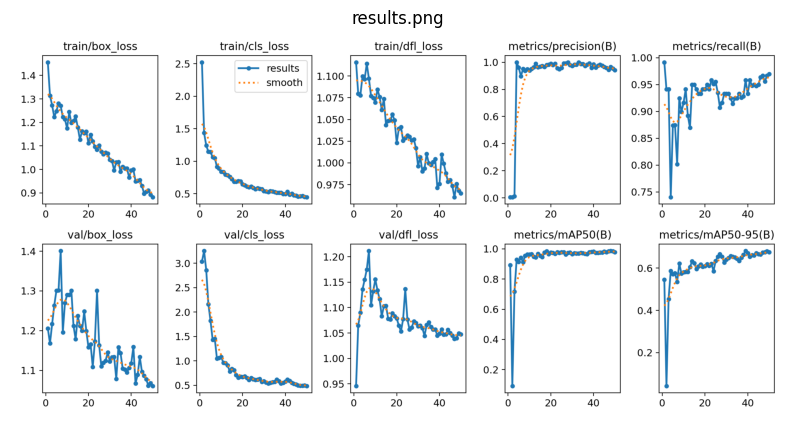

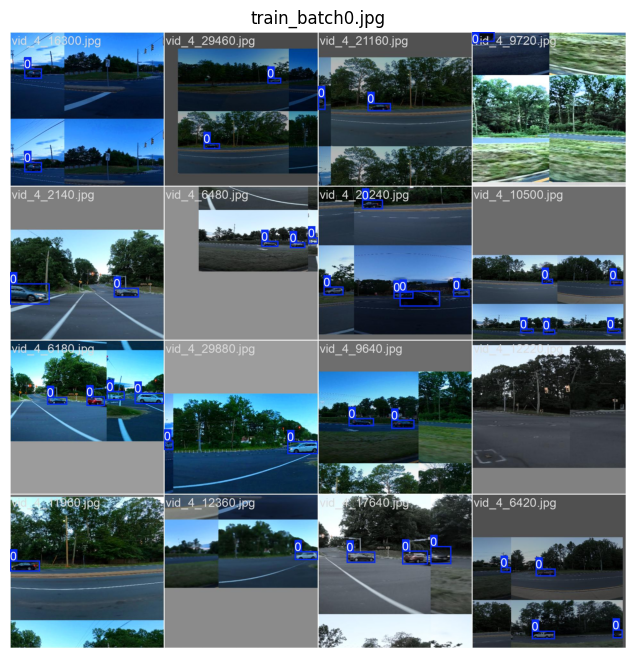

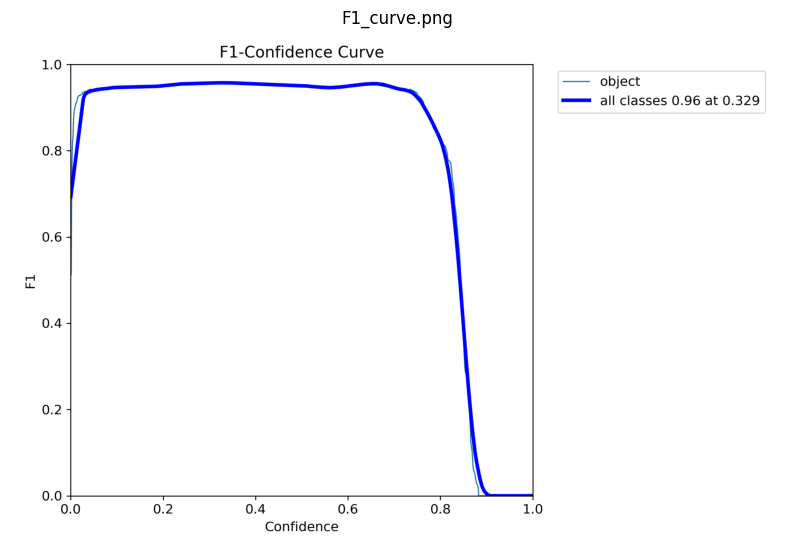

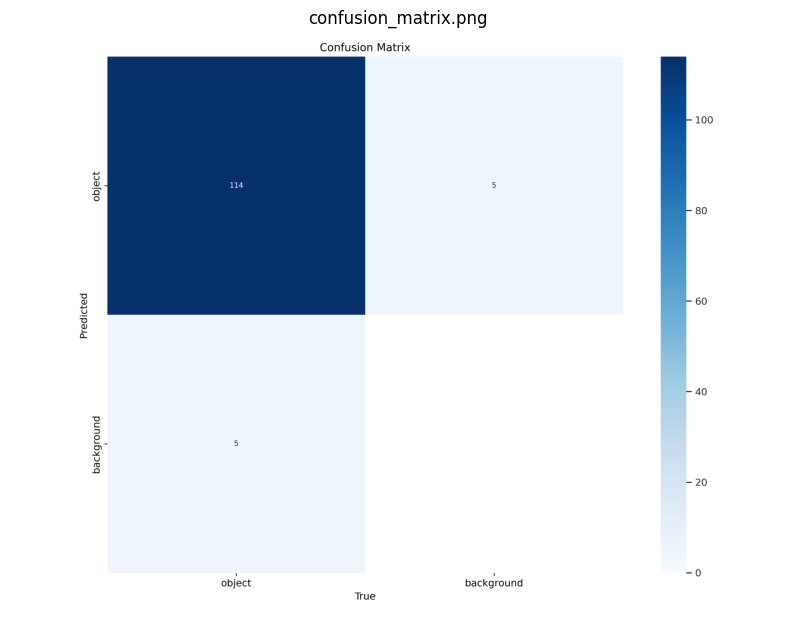

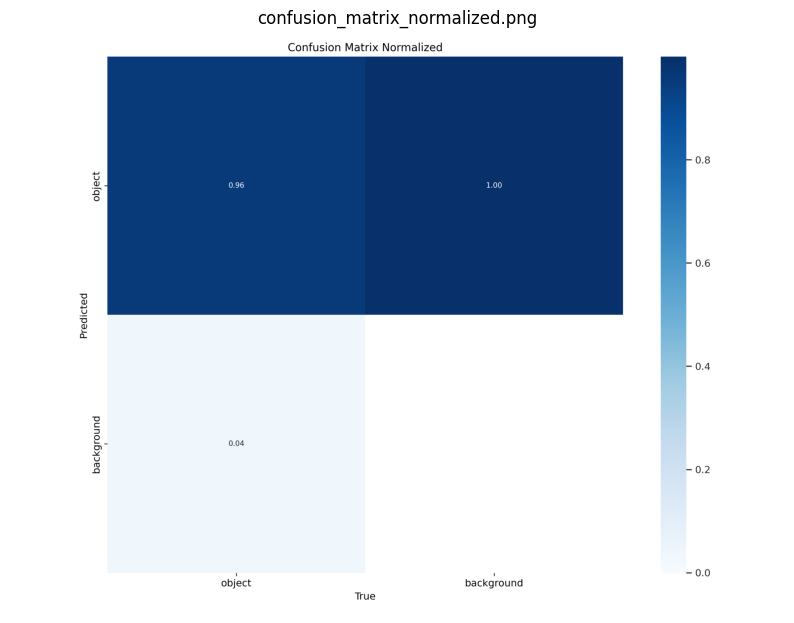

In [65]:
def display_image(image_path):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

results_path = "/content/runs/detect/train2/results.png"
train_batch_path = "/content/runs/detect/train2/train_batch0.jpg"
f1_path = "/content/runs/detect/val/F1_curve.png"
confusion_matrix_path = "/content/runs/detect/val/confusion_matrix.png"
confusion_matrix_normalize_path = "/content/runs/detect/train2/confusion_matrix_normalized.png"

# results.png
display_image(results_path)

# train_batch0.jpg
display_image(train_batch_path)

display_image(f1_path)

display_image(confusion_matrix_path)

display_image(confusion_matrix_normalize_path)



Displaying results for 5 images out of 71 total images.

image 1/1 /content/yolo_dataset/val/images/vid_4_16060.jpg: 384x640 1 object, 160.7ms
Speed: 16.6ms preprocess, 160.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


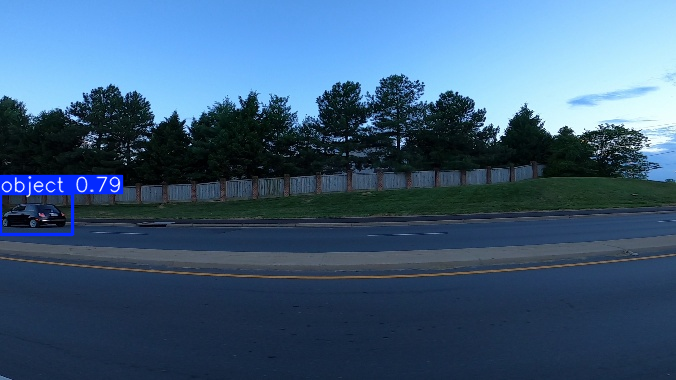


image 1/1 /content/yolo_dataset/val/images/vid_4_6340.jpg: 384x640 2 objects, 213.3ms
Speed: 3.8ms preprocess, 213.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


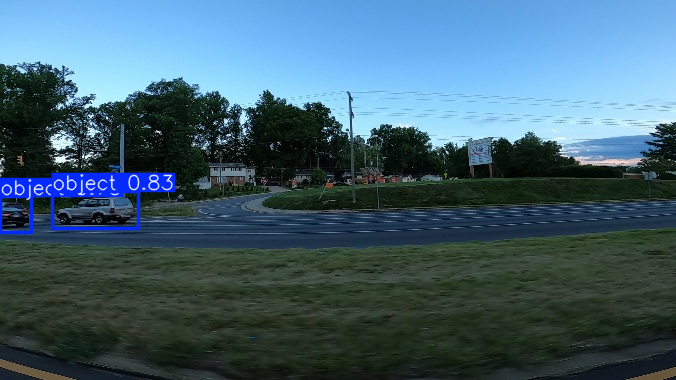


image 1/1 /content/yolo_dataset/val/images/vid_4_9880.jpg: 384x640 1 object, 215.5ms
Speed: 4.8ms preprocess, 215.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


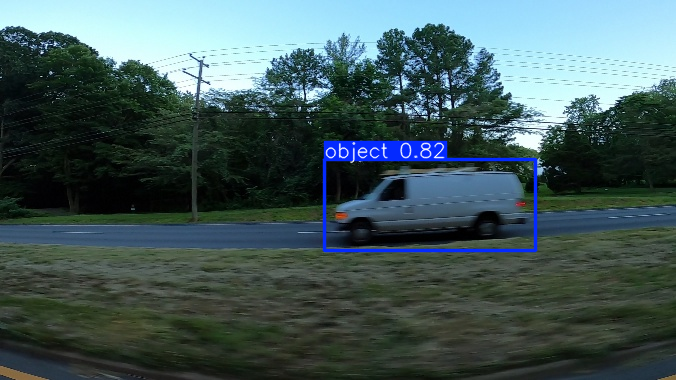


image 1/1 /content/yolo_dataset/val/images/vid_4_30440.jpg: 384x640 1 object, 260.2ms
Speed: 3.8ms preprocess, 260.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


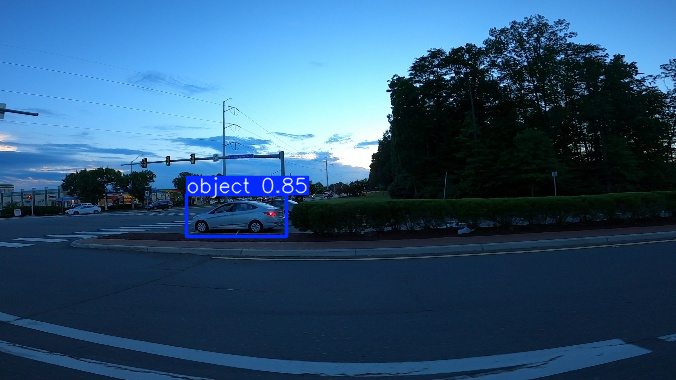


image 1/1 /content/yolo_dataset/val/images/vid_4_12300.jpg: 384x640 3 objects, 265.7ms
Speed: 4.0ms preprocess, 265.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


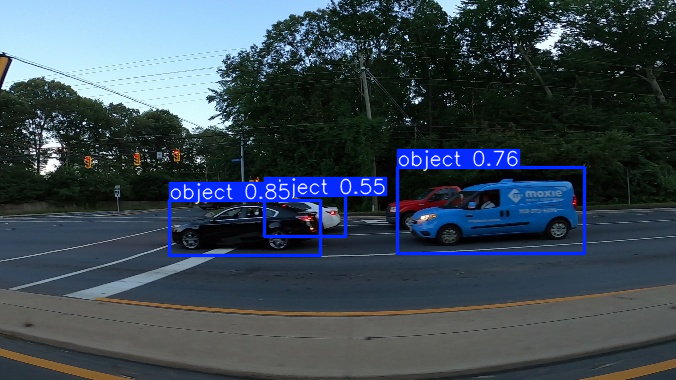

In [66]:
def evaluate_yolov8_in_memory(model_path, images_path, conf=0.5, max_images=5):

    model = YOLO(model_path)

    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    display_files = image_files[:max_images]
    print(f"Displaying results for {len(display_files)} images out of {len(image_files)} total images.")

    for image_file in display_files:
        image_path = os.path.join(images_path, image_file)

        results = model.predict(source=image_path, conf=conf)

        for result in results:
            result.show()


model_path = "/content/runs/detect/train2/weights/best.pt"
test_images_path = "/content/yolo_dataset/val/images"

evaluate_yolov8_in_memory(model_path=model_path, images_path=test_images_path, conf=0.5, max_images=5)

In [67]:
import shutil


shutil.make_archive('/content/yolo_dataset', 'zip', '/content/yolo_dataset')

shutil.make_archive('/content/runs', 'zip', '/content/runs')

print("ziped")


ziped
